In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
import copy
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import LinearRegression

### Dataset


---
To ensure a stable supply of rental bikes in urban cities, it is important to accurately predict the bike count required at each hour. This helps reduce waiting time and enhance mobility comfort for the public. The dataset contains weather information (Temperature, Humidity, Windspeed, Visibility, Dewpoint, Solar radiation, Snowfall, Rainfall), the number of bikes rented per hour and date information.

---
\\

Seoul Bike Sharing Demand. (2020). UCI Machine Learning Repository [https://archive.ics.uci.edu/dataset/560/seoul+bike+sharing+demand]. https://doi.org/10.24432/C5F62R.

\\

In [2]:
dataset_cols=["bike_count", "hour", "temp", "humidity", "wind", "visibility", "dew_pt_temp", "radiation", "rain", "snow", "functional"]
df=pd.read_csv("SeoulBikeData.csv").drop(["Date", "Holiday", "Seasons"], axis=1)

In [3]:
df.columns=dataset_cols
df["functional"]=(df["functional"] == "Yes").astype(int) #The computer is really good at understanding numbers
df=df[df["hour"] == 12]
df=df.drop(["hour"], axis=1)

In [4]:
df.head()

,bike_count,temp,humidity,wind,visibility,dew_pt_temp,radiation,rain,snow,functional
12,449,1.7,23,1.4,2000,-17.2,1.11,0.0,0.0,1
36,479,4.3,41,1.3,1666,-7.8,1.09,0.0,0.0,1
60,333,5.8,85,1.7,349,3.4,0.43,0.0,0.0,1
84,393,-0.3,38,4.8,1823,-12.9,1.11,0.0,0.0,1
108,321,-2.3,25,0.0,1962,-19.7,0.00,0.0,0.0,1


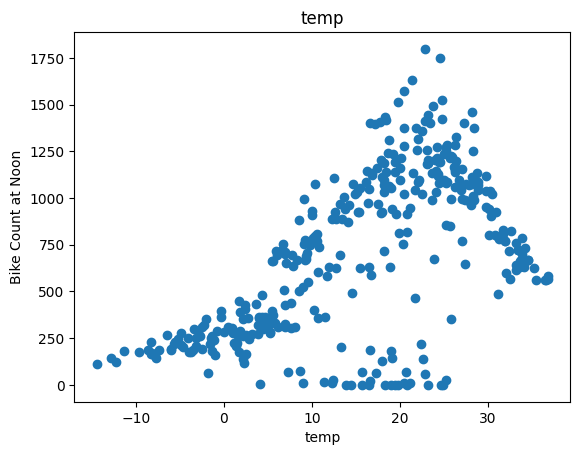

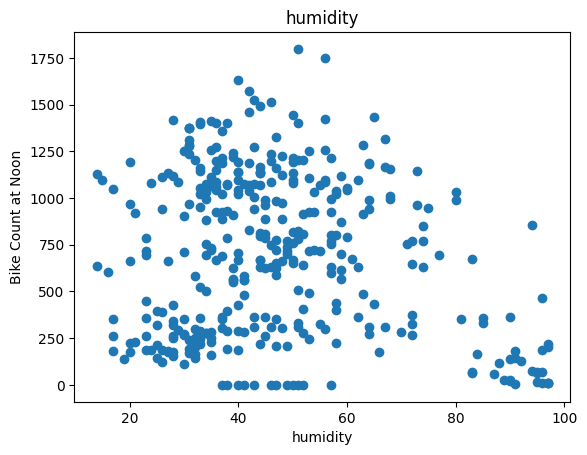

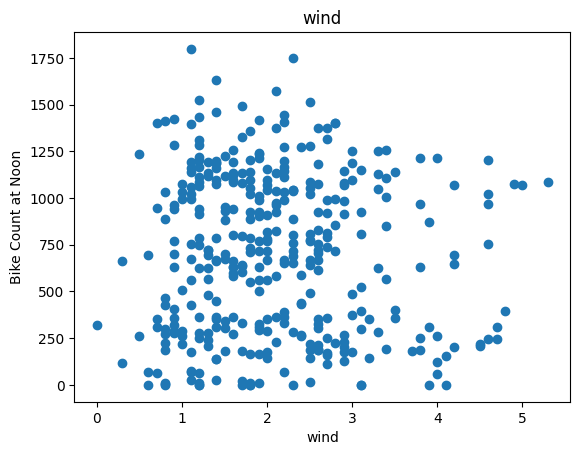

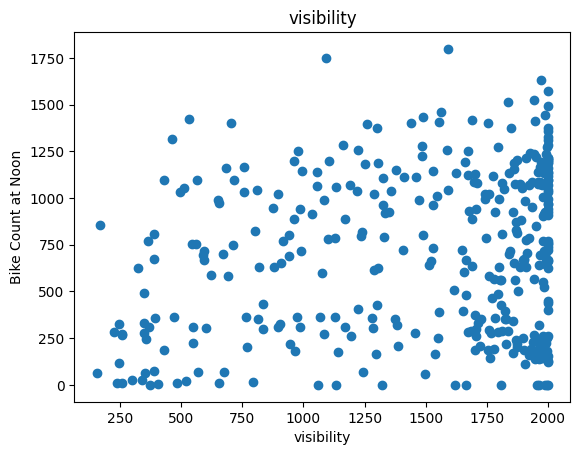

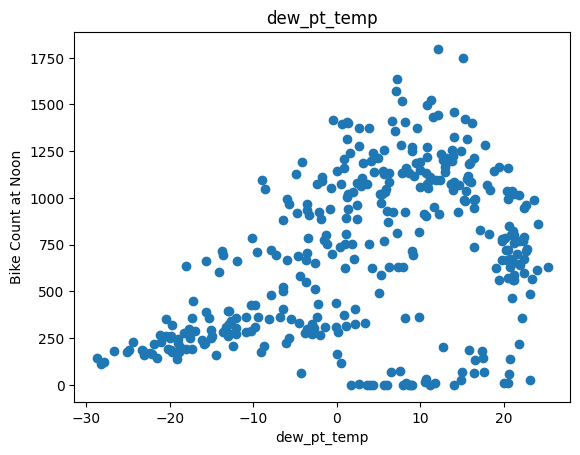

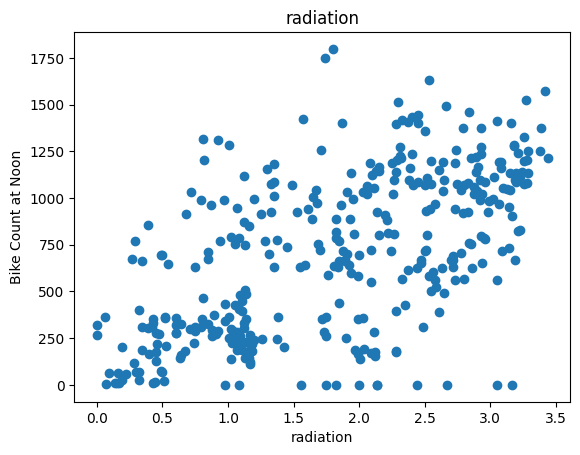

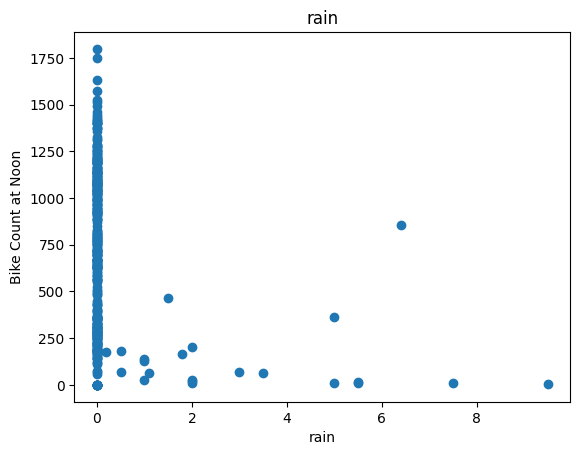

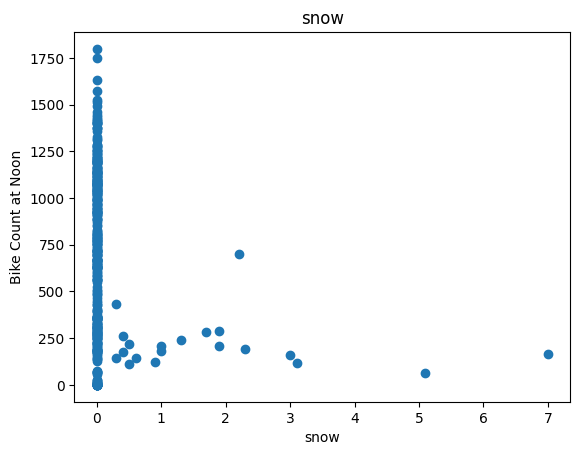

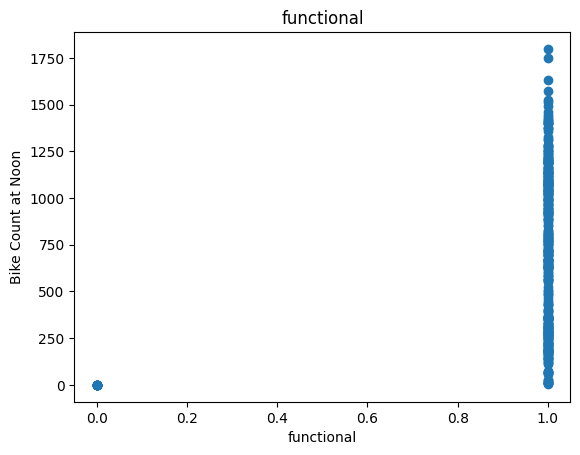

In [5]:
for label in df.columns[1:]:
  plt.scatter(df[label], df["bike_count"])
  plt.title(label)
  plt.ylabel("Bike Count at Noon")
  plt.xlabel(label)
  plt.show() #the bike count doesn't appear linear with respect to some of these features

In [6]:
df=df.drop(["wind", "visibility", "functional"], axis=1)

In [7]:
df.head()

,bike_count,temp,humidity,dew_pt_temp,radiation,rain,snow
12,449,1.7,23,-17.2,1.11,0.0,0.0
36,479,4.3,41,-7.8,1.09,0.0,0.0
60,333,5.8,85,3.4,0.43,0.0,0.0
84,393,-0.3,38,-12.9,1.11,0.0,0.0
108,321,-2.3,25,-19.7,0.00,0.0,0.0


#Train/valid/test dataset

In [8]:
train, val, test=np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])

This basically means everything between 60% and 80% of the length of the dataset will go towards validation. Like everything from 80% to 100%, I'm going to pass my test data.

In [10]:
def get_xy(dataframe, y_label, x_labels=None):
  dataframe = copy.deepcopy(dataframe)
  if x_labels is None:
    X = dataframe[[c for c in dataframe.colums if c!=y_label]].values
  else:
    if len(x_labels) == 1:
      X = dataframe[x_labels[0]].values.reshape(-1,1)
    else:
      X = dataframe[x_labels].values

  y = dataframe[y_label].values.reshape(-1,1)
  data = np.hstack((X,y))

  return data, X, y

In [11]:
_, X_train_temp, y_train_temp =get_xy(train, "bike_count", x_labels=["temp"]) #we have our training validation and test dataset for just the temperature
_, X_val_temp, y_val_temp =get_xy(val, "bike_count", x_labels=["temp"])
_, X_test_temp, y_test_temp =get_xy(test, "bike_count", x_labels=["temp"])

In [12]:
temp_reg=LinearRegression()
temp_reg.fit(X_train_temp, y_train_temp)

LinearRegression()

In [13]:
temp_reg.score(X_test_temp, y_test_temp) #if the number is bigger that's mean is more correlated

0.35593423981422456

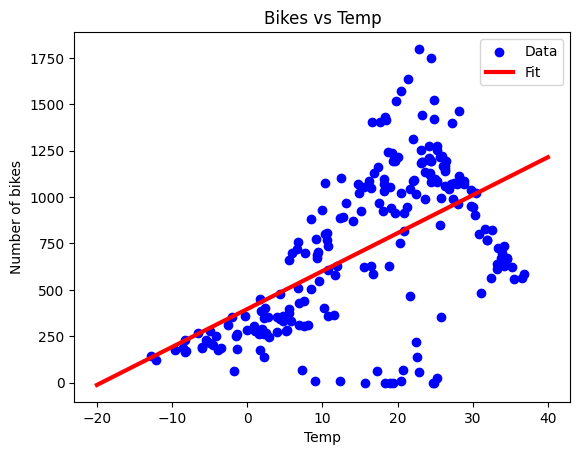

In [14]:
plt.scatter(X_train_temp, y_train_temp, label="Data", color="blue")
x=tf.linspace(-20,40,100)
plt.plot(x, temp_reg.predict(np.array(x).reshape(-1,1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Number of bikes")
plt.xlabel("Temp")
plt.show()

#Multiple Linear Regression

In [15]:
train, val, test=np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])

_, X_train_all, y_train_all =get_xy(train, "bike_count", x_labels=df.columns[1:])
_, X_val_all, y_val_all =get_xy(val, "bike_count", x_labels=df.columns[1:])
_, X_test_all, y_test_all =get_xy(test, "bike_count", x_labels=df.columns[1:])

In [16]:
all_reg = LinearRegression()
all_reg.fit(X_train_all, y_train_all)

LinearRegression()

In [18]:
all_reg.score(X_test_all, y_test_all)

0.5135063417333688

In [19]:
y_pred_lr = all_reg.predict(X_test_all)

#Regression with Neural Net

In [20]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('MSE')
  plt.legend()
  plt.grid(True)
  plt.show()

In [21]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None)
temp_normalizer.adapt(X_train_temp.reshape(-1))

In [22]:
temp_nn_model=tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(1) #one single node just means that it's linear
])

In [23]:
temp_nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss='mean_squared_error')

In [24]:
history = temp_nn_model.fit(
    X_train_temp.reshape(-1), y_train_temp,
    verbose=0,
    epochs=1000,
    validation_data=(X_val_temp, y_val_temp)
)

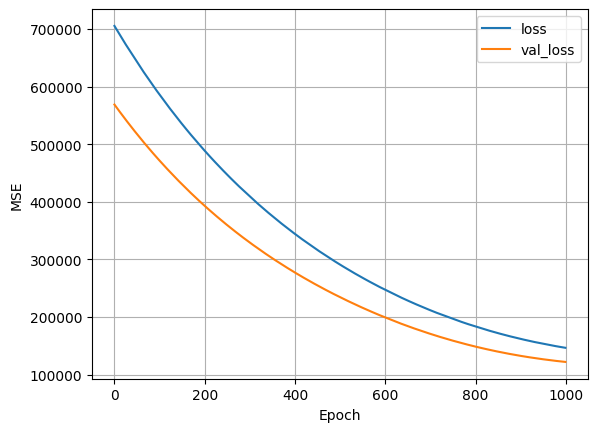

In [25]:
plot_loss(history)

4/4 [==============================] - 0s 4ms/step


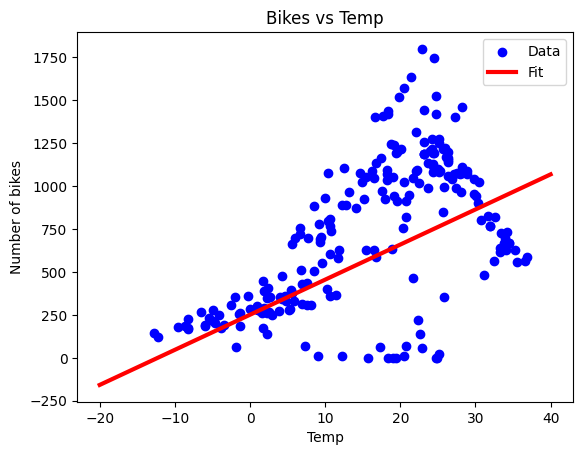

In [26]:
plt.scatter(X_train_temp, y_train_temp, label="Data", color="blue")
x=tf.linspace(-20,40,100)
plt.plot(x, temp_nn_model.predict(np.array(x).reshape(-1,1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Number of bikes")
plt.xlabel("Temp")
plt.show()

#Neuronal Net

In [31]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None)
temp_normalizer.adapt(X_train_temp.reshape(-1))

nn_model=tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'), #We can apply as many layers as necessary to obtain a good result.
    tf.keras.layers.Dense(1) #1 answer
])
nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

In [32]:
history = nn_model.fit(
    X_train_temp, y_train_temp,
    validation_data=(X_val_temp, y_val_temp),
    verbose=0, epochs=100
)

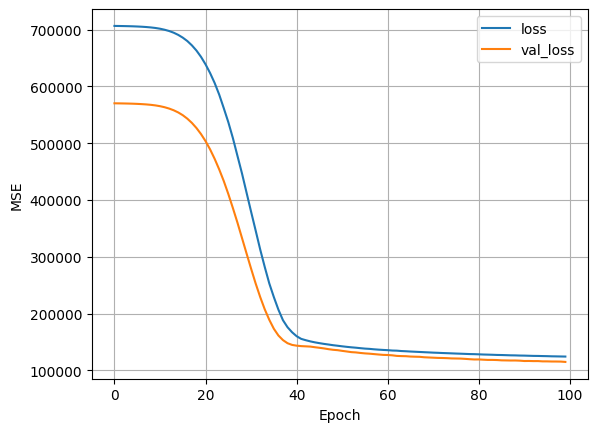

In [29]:
plot_loss(history)

4/4 [==============================] - 0s 3ms/step


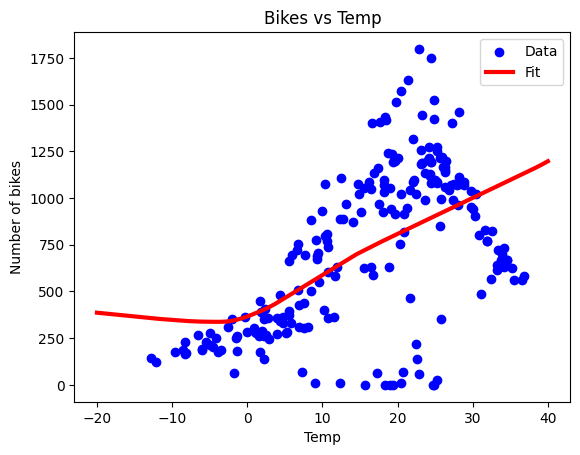

In [30]:
plt.scatter(X_train_temp, y_train_temp, label="Data", color="blue")
x=tf.linspace(-20,40,100)
plt.plot(x, nn_model.predict(np.array(x).reshape(-1,1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Number of bikes")
plt.xlabel("Temp")
plt.show()

In [33]:
all_normalizer = tf.keras.layers.Normalization(input_shape=(6,), axis=-1)
all_normalizer.adapt(X_train_all)

In [34]:
nn_model=tf.keras.Sequential([
    all_normalizer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1) #1 answer
])
nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

In [35]:
history = nn_model.fit(
    X_train_all, y_train_all,
    validation_data=(X_val_all, y_val_all),
    verbose=0, epochs=100
)

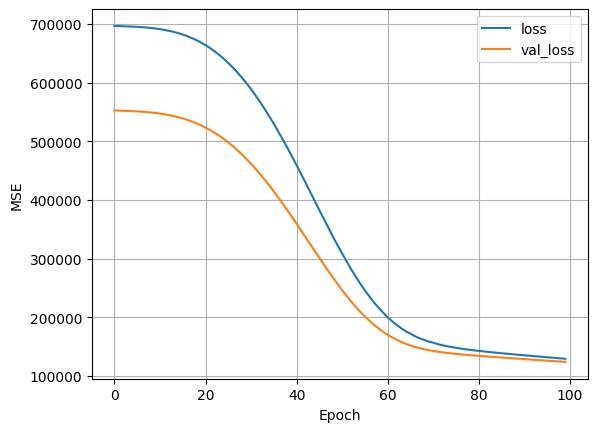

In [36]:
plot_loss(history)

In [37]:
#calculate the MSE for both linear reg and nn
y_pred_lr = all_reg.predict(X_test_all)
y_pred_nn = nn_model.predict(X_test_all)

3/3 [==============================] - 0s 4ms/step


In [38]:
def MSE(y_pred, y_real):
  return (np.square(y_pred - y_real)).mean()

In [39]:
MSE(y_pred_lr, y_test_all)

110091.31345682974

In [40]:
MSE(y_pred_nn, y_test_all)

139615.43386493405

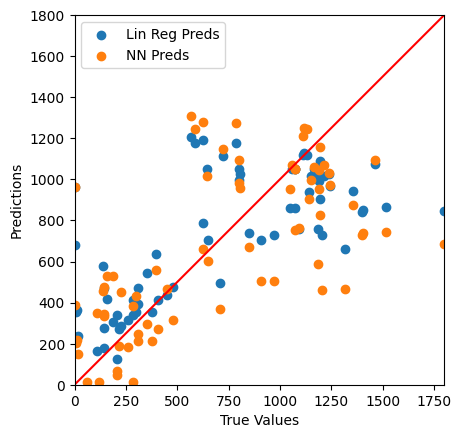

In [41]:
ax=plt.axes(aspect="equal")
plt.scatter(y_test_all, y_pred_lr, label="Lin Reg Preds")
plt.scatter(y_test_all, y_pred_nn, label="NN Preds")
plt.xlabel("True Values")
plt.ylabel("Predictions")
lims=[0,1800]
plt.xlim(lims)
plt.ylim(lims)
plt.legend()
_=plt.plot(lims, lims, c="red")